In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 6s 0us/step


In [3]:
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'README', 'test', 'imdbEr.txt']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['unsup',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_pos.txt',
 'neg']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
#ładowanie zbioru danych
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed

)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f"recenzja: {text_batch.numpy()[i]}")
    print(f"etykieta: {label_batch.numpy()[i]}")
print(f"etykieta 0 to recenzja: {raw_train_ds.class_names[0]}")
print(f"etykieta 1 to recenzja: {raw_train_ds.class_names[1]}")

#dane walidacyjne i testowe
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed

)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
    
)

#przygotowanie zbioru danych do szkolenia....
def custom_standarization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standarization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

def vectorize_text(text,label):
  text=tf.expand_dims(text,-1)
  return vectorize_layer(text), label


text_batch,label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f"recenzja: {first_review}")
print(f"etykieta: {raw_train_ds.class_names[first_label]}")
print(f"Zwektoryzowana recenzja: {vectorize_text(first_review,first_label)}")

print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 --> {vectorize_layer.get_vocabulary()[313]}")

recenzja: b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'
etykieta: 0
recenzja: b'Wow. The only people reviewing this positively are the Carpenter apologists. I know a lot of those. The guys that\'ll watch John Carpenter squat on celluloid and pinch out a movie and proclaim it a masterwork

In [10]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [11]:
#konfiguracja zbioru pod kątem wydajności
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
#tworzenie modelu
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


In [16]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 14s 21ms/step - loss: 0.6628 - binary_accuracy: 0.6963 - val_loss: 0.6130 - val_binary_accuracy: 0.7750
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.5472 - binary_accuracy: 0.8036 - val_loss: 0.4968 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 10s 15ms/step - loss: 0.4438 - binary_accuracy: 0.8482 - val_loss: 0.4190 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 0.3772 - binary_accuracy: 0.8663 - val_loss: 0.3728 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 7s 12ms/step - loss: 0.3351 - binary_accuracy: 0.8790 - val_loss: 0.3442 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3036 - binary_accuracy: 0.8899 - val_loss: 0.3251 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 7s

In [17]:
#ocena modelu
loss,accuracy = model.evaluate(test_ds)
print(f"Strata: {loss}")
print(f"Dokładność: {accuracy}")

782/782 [==============================] - 11s 14ms/step - loss: 0.3097 - binary_accuracy: 0.8740
Strata: 0.30974045395851135
Dokładność: 0.8740000128746033


In [18]:
#wykres dokładności i strat w czasie
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

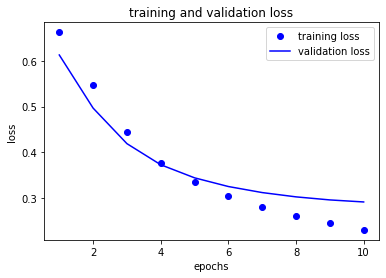

In [20]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

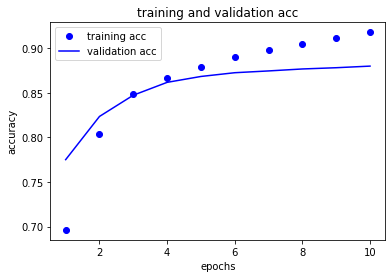

In [21]:
plt.plot(epochs,acc,'bo',label='training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('training and validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
#eksport modelu
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics = ['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3097 - accuracy: 0.8740
0.8740000128746033
